In [1]:
import openai
from conversational_ai_with_rag import retrieve_relevant_documents, re_rank_documents, generate_response
from serpapi import GoogleSearch
import json
import re
import pandas as pd
from tqdm import tqdm


openai.api_key = ''
serpapi_key = ""
fine_tuned_model_id = 'ft:gpt-3.5-turbo-0125:personal:umroh-ai-mvp-29jul:9qAxDEDg'

In [2]:
params_general_search = {
  "api_key": serpapi_key,
  "engine": "google",
  "q": "jadwal sholat masjid nabawi",
  "location": "Austin, Texas, United States",
  "google_domain": "google.com",
  "gl": "us",
  "hl": "en"
}

params_local_food = {
  "api_key": serpapi_key,
  "engine": "google_local",
  "google_domain": "google.com",
  "q": "indonesian restaurant in madinah"
}

params_local_tourism = {
  "api_key": serpapi_key,
  "engine": "google_local",
  "google_domain": "google.com",
  "q": "tempat wisata di riyadh"
}

params_direction = {
  "api_key": serpapi_key,
  "engine": "google_maps_directions",
  "q": "Coffee",
  "hl": "en",
  "start_addr": "makkah",
  "end_addr": "madinah",
  "travel_mode": "3"
}

params_flights = {
  "api_key": serpapi_key,
  "engine": "google_flights",
  "hl": "en",
  "gl": "us",
  "departure_id": "MAN",
  "arrival_id": "JED",
  "outbound_date": "2024-08-01",
  "return_date": "2024-08-07",
  "currency": "USD"
}

params = {
  "api_key": serpapi_key,
  "engine": "google_hotels",
  "q": "hotel in jeddah",
  "hl": "en",
  "gl": "us",
  "check_in_date": "2024-08-01",
  "check_out_date": "2024-08-02",
  "currency": "USD",
  "adults": "2",
  "children": "1",
  "children_ages": "2"
}

def get_result(params):
    search = GoogleSearch(params)
    results = search.get_dict()
    return results

In [3]:
def determine_usefulness_and_scraping(query, documents):
    context = "\n\n".join(documents)
    examples = """
    Example 1: {"engine": "google", "q": "jadwal sholat masjid nabawi", "location": "Austin, Texas, United States", "google_domain": "google.com", "gl": "us", "hl": "en"}
    
    Example 2: {"engine": "google_local", "google_domain": "google.com", "q": "indonesian restaurant in madinah"}
    
    Example 3: {"engine": "google_local", "google_domain": "google.com", "q": "tempat wisata di riyadh"}
    
    Example 4: {"engine": "google_maps_directions", "q": "Coffee", "hl": "en", "start_addr": "makkah", "end_addr": "madinah", "travel_mode": "3"}
    
    Example 5: {"engine": "google_flights", "hl": "en", "gl": "us", "departure_id": "MAN", "arrival_id": "JED", "outbound_date": "2024-08-01", "return_date": "2024-08-07", "currency": "USD"}
    
    Example 6: {"engine": "google_hotels", "q": "hotel in jeddah", "hl": "en", "gl": "us", "check_in_date": "2024-08-01", "check_out_date": "2024-08-02", "currency": "USD", "adults": "2", "children": "1", "children_ages": "2"}
    """
    
    messages = [
        {"role": "system", "content": "You are an AI assistant. Your tasks are to: 1) Determine whether the retrieved documents are useful for answering the user's main query. If not, ignore the documents; if they are helpful, use them as context. 2) Assess whether the user's query requires web scraping and identify the type of web scraping needed from the given five types: google search, google local, google maps directions, google flights, or google hotels. 3) Generate the appropriate parameters for the SerpAPI call based on the user's query and examples provided. 4) Your output should ALWAYS be in a dictionary format like this:\n {'user_query': ... , \n'Context from RAG' (if any): ..., \n 'Scraping Params': ..., }\nYou will communicate this output to the fine-tuned model to generate the final response."},
        {"role": "user", "content": query},
        {"role": "assistant", "content": context},
        {"role": "system", "content": "Here are some examples of search parameters for different types of queries: " + examples}
    ]
    
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=1500,
    )
    result = response.choices[0].message.content
    
    # Process results
    try:
        result = eval(result)
        useful_docs = result['Context from RAG']
        scraping_params = result['Scraping Params']
    except:
        try:
            useful_docs = result.split('Context from RAG (if any):')[1].split('Scraping Params')[0]
            scraping_params = result.split('Scraping Params: ')[1]
        except:
#             print("Error parsing scraping params:", result)
            scraping_params = {}
            useful_docs= ""
    return {"useful_docs": useful_docs, "scraping_params": scraping_params}

def perform_web_scraping(params, serpapi_key=serpapi_key):
    serpapi_key = serpapi_key
    search = GoogleSearch(params)
    results = search.get_dict()
    return results

def generate_final_response(query, relevant_texts, scraping_results='', fine_tuned_model=fine_tuned_model_id):
    web_scraping_data = json.dumps(scraping_results)
    if len(web_scraping_data)>10000:
        web_scraping_data = web_scraping_data[:10000]
    if relevant_texts:
        if len(relevant_texts)>5000:
            relevant_texts = relevant_texts[:5000]
        
    # Construct the context, emphasizing the use of web-scraped data
    context = f"Use the following real-time web-scraped data to provide an accurate response: {web_scraping_data}\n\nAdditional context from relevant documents: {relevant_texts}"
    
    # Messages to instruct the AI model
    messages = [
        {"role": "system", "content": (
            "You are an AI assistant with expertise in Umrah & Hajj. You will receive a query, real-time web-scraped data, and additional context from relevant documents. "
            "If the web-scraped data is relevant and helpful for answering the query, PRIORITIZE using it. "
            "ALWAYS integrate the web-scraped data into your response when applicable. "
            "If the query is not related to Hajj or Umrah but can be answered using the web-scraped data, use the web-scraped data to provide the response, clearly stating it as the source. "
            "If no relevant information is available in either the documents or web-scraped data, respond respectfully stating it's outside your expertise."
        )},
        {"role": "user", "content": query},
        {"role": "assistant", "content": context}
    ]
    
    response = openai.chat.completions.create(
        model=fine_tuned_model,
        messages=messages,
        max_tokens=2048,
    )
    return response.choices[0].message.content

In [5]:
def main(query):
    query = query
    # Step 1-3: Retrieve and re-rank documents
    initial_relevant_texts = retrieve_relevant_documents(query)
    re_ranked_texts = re_rank_documents(query, initial_relevant_texts)

    # Use GPT-3.5 to determine document usefulness and scraping needs
    analysis = determine_usefulness_and_scraping(query, re_ranked_texts[0][:1500])

    # Extract information from the analysis
    useful_docs = analysis['useful_docs']
    print('USEFUL DOCS FROM RAG: ', useful_docs)

    scraping_params = {'api_key':serpapi_key}
    scraping_params.update(analysis['scraping_params'])
#     print('SCRAPING PARAMS by GPT: ', scraping_params)


    scraping_results = {}
    if scraping_params:
        # Perform web scraping
        scraping_results = perform_web_scraping(scraping_params)
    print('SCRAPING RESULTS : ', scraping_results)

    # Generate the final response
    response = generate_final_response(query, useful_docs, scraping_results)
    print("--"*40, "\nGenerated Response:", response)

In [6]:
if __name__ == "__main__":
    main(query="Can you give me a price comparison summary of available hotels in Riyadh on 14th to 18th of September 2024?")

C:\Users\PF4AA\OneDrive\Documents\Self Learning\Personal_porto\AI_Assistant_Umrah\MVP_Creation\umrah_env\lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


USEFUL DOCS FROM RAG:  N/A
SCRAPING RESULTS :  {'search_metadata': {'id': '66e46b4b23a4b50f1e6d9656', 'status': 'Success', 'json_endpoint': 'https://serpapi.com/searches/045bba9b7c9860fb/66e46b4b23a4b50f1e6d9656.json', 'created_at': '2024-09-13 16:41:47 UTC', 'processed_at': '2024-09-13 16:41:47 UTC', 'google_hotels_url': 'https://www.google.com/_/TravelFrontendUi/data/batchexecute?rpcids=AtySUc&source-path=/travel/search&hl=en&gl=us&rt=c&soc-app=162&soc-platform=1&soc-device=1', 'raw_html_file': 'https://serpapi.com/searches/045bba9b7c9860fb/66e46b4b23a4b50f1e6d9656.html', 'prettify_html_file': 'https://serpapi.com/searches/045bba9b7c9860fb/66e46b4b23a4b50f1e6d9656.prettify', 'total_time_taken': 2.0}, 'search_parameters': {'engine': 'google_hotels', 'q': 'hotels in Riyadh', 'gl': 'us', 'hl': 'en', 'currency': 'USD', 'check_in_date': '2024-09-14', 'check_out_date': '2024-09-18', 'adults': 1, 'children': 0}, 'search_information': {'total_results': 6270}, 'brands': [{'id': 33, 'name': 'A

-------------------------------------------------------------------------------- 
Generated Response: I can provide you with a price comparison summary of available hotels in Riyadh from 14th to 18th September 2024. Here are two options:

1. Melissa Hotel Riyadh:
   - Price: $126 per night (24% less than usual)
   - Total price for 4 nights: $505
   - Class: 4-star hotel
   - Rating: 4.1
   - Amenities: Includes breakfast, free Wi-Fi, pool, spa, restaurant, and more.
   - Link: [Melissa Hotel Riyadh](http://www.melissahotelriyadh-riyadh.website/)

2. فندق ميرتل الصحافة - Myrtle Hotel Al Sahafah:
   - Price: $94 per night (28% less than usual)
   - Total price for 4 nights: $378
   - Class: 4-star hotel
   - Rating: N/A
   - Amenities: N/A
   - Link: [Myrtle Hotel Al Sahafah](https://www.myrtle-hotels.com/ar)

These options provide different price points for your stay in Riyadh.


In [7]:
main(query="I want to go umrah. Can you give me a price comparison for flights from London to Jeddah on 14th to 21st of September 2024?")

USEFUL DOCS FROM RAG:  NA
SCRAPING RESULTS :  {'search_metadata': {'id': '66e46b5ae30abcc171c2d03a', 'status': 'Success', 'json_endpoint': 'https://serpapi.com/searches/e7b67e5a5afaae01/66e46b5ae30abcc171c2d03a.json', 'created_at': '2024-09-13 16:42:02 UTC', 'processed_at': '2024-09-13 16:42:02 UTC', 'google_flights_url': 'https://www.google.com/travel/flights?hl=en&gl=uk&curr=GBP&tfs=CBwQAhoeEgoyMDI0LTA5LTE0agcIARIDTEhScgcIARIDSkVEGh4SCjIwMjQtMDktMjFqBwgBEgNKRURyBwgBEgNMSFJCAQFIAXABmAEB', 'raw_html_file': 'https://serpapi.com/searches/e7b67e5a5afaae01/66e46b5ae30abcc171c2d03a.html', 'prettify_html_file': 'https://serpapi.com/searches/e7b67e5a5afaae01/66e46b5ae30abcc171c2d03a.prettify', 'total_time_taken': 2.16}, 'search_parameters': {'engine': 'google_flights', 'hl': 'en', 'gl': 'uk', 'departure_id': 'LHR', 'arrival_id': 'JED', 'outbound_date': '2024-09-14', 'return_date': '2024-09-21', 'currency': 'GBP'}, 'best_flights': [{'flights': [{'departure_airport': {'name': 'Heathrow Airport'

-------------------------------------------------------------------------------- 
Generated Response: I found flight options for your Umrah trip from London to Jeddah on 14th to 21st September 2024. Here are some of the best round-trip flights:  
1. Turkish Airlines with a layover in Istanbul,  total duration 690 mins, £550.  
2. Aegean Airlines with a layover in Athens, total duration 740 mins, £708.  
3. Saudia Airlines with a layover in Riyadh, total duration 695 mins, £749.  
4. Qatar Airways with a layover in Doha, total duration 610 mins, £835.  
These options vary in price, duration, and airlines. Let me know if you need more details!


In [8]:
main(query="I want to book flight tickets from london to jakarta for 4 person round trip from 26 September to 4 October 2024. Can you give me detailed costs for that please?")

USEFUL DOCS FROM RAG:  None
SCRAPING RESULTS :  {'search_metadata': {'id': '66e46b6315c740c91a26f1b2', 'status': 'Success', 'json_endpoint': 'https://serpapi.com/searches/edd2a9fa1734affd/66e46b6315c740c91a26f1b2.json', 'created_at': '2024-09-13 16:42:11 UTC', 'processed_at': '2024-09-13 16:42:11 UTC', 'google_flights_url': 'https://www.google.com/travel/flights?hl=en&gl=uk&tfs=CBwQAhoeEgoyMDI0LTA5LTI2agcIARIDTEhScgcIARIDQ0dLGh4SCjIwMjQtMTAtMDRqBwgBEgNDR0tyBwgBEgNMSFJCBAEBAQFIAXABmAEB', 'raw_html_file': 'https://serpapi.com/searches/edd2a9fa1734affd/66e46b6315c740c91a26f1b2.html', 'prettify_html_file': 'https://serpapi.com/searches/edd2a9fa1734affd/66e46b6315c740c91a26f1b2.prettify', 'total_time_taken': 0.53}, 'search_parameters': {'engine': 'google_flights', 'hl': 'en', 'gl': 'uk', 'departure_id': 'LHR', 'arrival_id': 'CGK', 'outbound_date': '2024-09-26', 'return_date': '2024-10-04', 'adults': 4}, 'best_flights': [{'flights': [{'departure_airport': {'name': 'Heathrow Airport', 'id': '

-------------------------------------------------------------------------------- 
Generated Response: I currently do not have access to real-time flight data. Please let me know if you need assistance with anything else.


In [9]:
main(query="I want to go Umrah next week from 21st - 27th September 2024, can you compare price of flights from London to Jeddah available for me?")

USEFUL DOCS FROM RAG:  I want to go Umrah next week from 21st - 27th September 2024
SCRAPING RESULTS :  {'search_metadata': {'id': '66e46b6acdf155e7001ee4d9', 'status': 'Success', 'json_endpoint': 'https://serpapi.com/searches/e7b67e5a5afaae01/66e46b6acdf155e7001ee4d9.json', 'created_at': '2024-09-13 16:42:18 UTC', 'processed_at': '2024-09-13 16:42:18 UTC', 'google_flights_url': 'https://www.google.com/travel/flights?hl=en&gl=uk&curr=GBP&tfs=CBwQAhoeEgoyMDI0LTA5LTIxagcIARIDTEhScgcIARIDSkVEGh4SCjIwMjQtMDktMjdqBwgBEgNKRURyBwgBEgNMSFJCAQFIAXABmAEB', 'raw_html_file': 'https://serpapi.com/searches/e7b67e5a5afaae01/66e46b6acdf155e7001ee4d9.html', 'prettify_html_file': 'https://serpapi.com/searches/e7b67e5a5afaae01/66e46b6acdf155e7001ee4d9.prettify', 'total_time_taken': 2.29}, 'search_parameters': {'engine': 'google_flights', 'hl': 'en', 'gl': 'uk', 'departure_id': 'LHR', 'arrival_id': 'JED', 'outbound_date': '2024-09-21', 'return_date': '2024-09-27', 'currency': 'GBP'}, 'best_flights': [{'fl

-------------------------------------------------------------------------------- 
Generated Response: I have real-time data on flights from London to Jeddah for your Umrah trip. Here are some options: 
1. British Airways with a layover, 19h 25m total duration, £473.
2. Gulf Air with a layover, 12h 25m total duration, £538.
3. Qatar Airways with a layover, 10h 15m total duration, £556.
4. Saudia non-stop, 8h 15m total duration, £605.


# Evaluation

In [12]:
qna_pair = pd.read_csv('Data/500-Umrah-related-question-answer-pair.csv')

sample_size = 150
sampled_df = qna_pair.groupby('Sumber', group_keys=False).apply(lambda x: x.sample(frac=sample_size/len(qna_pair)))
sampled_df.head()

C:\Users\PF4AA\AppData\Local\Temp\ipykernel_191404\4000518967.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = qna_pair.groupby('Sumber', group_keys=False).apply(lambda x: x.sample(frac=sample_size/len(qna_pair)))


,No,Pertanyaan,Jawaban,Sumber
183,184,Apa saja hal penting yang perlu dicatat selama...,"Halo bapak/ibu, hal penting yang perlu dicatat...",Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag
148,149,Bagaimana cara mengatur jadwal istirahat selam...,"Halo bapak/ibu, untuk mengatur jadwal istiraha...",Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag
147,148,Apa saja tips agar tetap tenang dan khusyuk se...,"Halo bapak/ibu, tips agar tetap tenang dan khu...",Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag
190,191,Bagaimana cara menginspirasi orang lain untuk ...,"Halo bapak/ibu, cara menginspirasi orang lain ...",Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag
118,119,Bagaimana cara berkomunikasi dengan keluarga d...,Cara berkomunikasi dengan keluarga di tanah ai...,Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag


In [13]:
# Initialize tqdm for pandas
tqdm.pandas()

In [153]:
def generate_gpt35_answer(question):
    """
    Generates an answer for a single question using GPT-3.5.
    
    Args:
        question (str): The question text.
        
    Returns:
        str: The answer generated by GPT-3.5.
    """
    messages = [
        {"role": "system", "content": "Answer the following question based on your knowledge."},
        {"role": "user", "content": question}
    ]
    
    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=messages,
            max_tokens=150,  
            temperature=0.7,  # trials
        )

        answer = response.choices[0].message.content.strip()
        return answer

    except Exception as e:
        print(f"Error occurred: {e}")
        return "Error generating answer"


def process_all_questions(sampled_df):
    """
    Processes all questions in the 'Pertanyaan' column and generates answers using GPT-3.5.
    
    Args:
        sampled_df (DataFrame): DataFrame containing the questions in 'Pertanyaan' column.
        
    Returns:
        DataFrame: Updated DataFrame with a new column 'GPT-3.5 Answer'.
    """
    # Apply the generate_gpt35_answer function to each question
    sampled_df['GPT-3.5 Answer'] = sampled_df['Pertanyaan '].apply(generate_gpt35_answer)
    return sampled_df

# Process the sampled DataFrame and generate answers
updated_df = process_all_questions(sampled_df)

In [159]:
updated_df

,No,Pertanyaan,Jawaban,Sumber,GPT-3.5 Answer
127,128,Apa saja fasilitas yang harus ada di penginapa...,"Halo bapak/ibu, fasilitas yang harus ada di pe...",Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag,Beberapa fasilitas yang sebaiknya ada di pengi...
114,115,Bagaimana cara menukar uang di Makkah dan Madi...,Menukar uang di Makkah dan Madinah bisa dilaku...,Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag,Anda dapat menukar uang di kota Makkah dan Mad...
10,11,Apa itu tahallul dalam umrah?,Tahallul umrah adalah keadaan seseorang setela...,Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag,Tahallul dalam umrah adalah proses melepaskan ...
5,6,Apa saja syarat umrah?,"Syarat umrah mencakup lima hal: 1) Islam, 2) B...",Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag,Syarat umrah adalah sebagai berikut:\n\n1. Ber...
27,28,Bagaimana cara mengganti niat ihram?,"Jika terjadi perubahan niat dalam ihram, seper...",Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag,"Untuk mengganti niat ihram, seseorang harus me..."
...,...,...,...,...,...
468,469,Bagaimana fiqh tentang Makkah?,Fiqh tentang Makkah meliputi beberapa hal: 1) ...,Panduan Ibadah Haji Sesuai Sunnah Nabi Oleh Ab...,Fiqh Makkah merujuk kepada hukum-hukum agama I...
400,401,Bagaimana cara minum air zamzam yang dianjurka...,Cara minum air zamzam yang dianjurkan oleh Nab...,Panduan Ibadah Haji Sesuai Sunnah Nabi Oleh Ab...,Nabi Muhammad shallallahu ‘alaihi wa sallam me...
393,394,Bagaimana cara ulama salaf memanfaatkan keutam...,Ulama salaf memanfaatkan keutamaan air zamzam ...,Panduan Ibadah Haji Sesuai Sunnah Nabi Oleh Ab...,Ulama salaf memanfaatkan keutamaan air zamzam ...
457,458,Apa kesalahan umum saat mencukur rambut setela...,Kesalahan saat mencukur rambut meliputi: 1) Me...,Panduan Ibadah Haji Sesuai Sunnah Nabi Oleh Ab...,Salah satu kesalahan umum saat mencukur rambut...


In [164]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

# Initialize Rouge and BLEU scorer
rouge = Rouge()
smoothie = SmoothingFunction().method4

# Function to calculate BLEU score
def calculate_bleu(reference, hypothesis):
    reference_tokens = [reference.split()]
    hypothesis_tokens = hypothesis.split()
    return sentence_bleu(reference_tokens, hypothesis_tokens, smoothing_function=smoothie)

# Function to calculate Cosine Similarity
def calculate_cosine_similarity(reference, hypothesis):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([reference, hypothesis])
    cosine_sim = cosine_similarity(vectors[0:1], vectors[1:2])
    return cosine_sim[0][0]

# Function to calculate metrics
def calculate_metrics(row):
    reference = row['Jawaban']
    hypothesis = row['GPT-3.5 Answer']

    # Calculate BLEU
    bleu_score = calculate_bleu(reference, hypothesis)

    # Calculate ROUGE
    rouge_scores = rouge.get_scores(hypothesis, reference, avg=True)

    # Calculate Cosine Similarity
    cosine_sim = calculate_cosine_similarity(reference, hypothesis)

    return pd.Series({
        'BLEU': bleu_score,
        'ROUGE-1': rouge_scores['rouge-1']['f'],
        'ROUGE-2': rouge_scores['rouge-2']['f'],
        'ROUGE-L': rouge_scores['rouge-l']['f'],
        'Cosine Similarity': cosine_sim
    })

# Apply the metric calculation function
updated_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Cosine Similarity']] = updated_df.apply(calculate_metrics, axis=1)

In [177]:
updated_df.iloc[:, -5:].describe().loc['mean']

BLEU                 0.052583
ROUGE-1              0.247671
ROUGE-2              0.086819
ROUGE-L              0.227996
Cosine Similarity    0.301720
Name: mean, dtype: float64

### Evaluation Customized Model

In [14]:
def ai_umrah_assistant_response(query):
    # Step 1-3: Retrieve and re-rank documents
    initial_relevant_texts = retrieve_relevant_documents(query)
    re_ranked_texts = re_rank_documents(query, initial_relevant_texts)

    # Use GPT-3.5 to determine document usefulness and scraping needs
    analysis = determine_usefulness_and_scraping(query, re_ranked_texts[0][:1500])

    # Extract information from the analysis
    useful_docs = analysis['useful_docs']
#     print('USEFUL DOCS FROM RAG: ', useful_docs)
    
    scraping_results = ''
    if analysis['scraping_params']:
        try: 
            scraping_params = {'api_key':serpapi_key}
            scraping_params.update(analysis['scraping_params'])
    #         print('SCRAPING PARAMS by GPT: ', scraping_params)

            scraping_results = {}
            if scraping_params:
                # Perform web scraping
                scraping_results = perform_web_scraping(scraping_params)
    #             print('SCRAPING RESULTS : ', scraping_results)
        except:
            if analysis['scraping_params']['q']:
                scraping_result = f"an attempt to search '{analysis['scraping_params']['q']}' is failed"
            else:
                scraping_result = 'An error occured when attempting to do web browsing, please try again.'

    # Generate the final response
    response = generate_final_response(query, useful_docs, scraping_results)
#     print("--"*40, "\nGenerated Response:", response)
    return response

In [16]:
query_test = 'Cari 3 hotel termurah di Riyadh yang available malam tanggal 06-07 September 2024'
response_test = ai_umrah_assistant_response(query_test)
print(response_test)

Berikut adalah 3 hotel termurah di Riyadh yang tersedia pada malam tanggal 06-07 September 2024 beserta harganya: 
1. Sheraton Riyadh Hotel & Towers - $162
2. The Ritz-Carlton, Riyadh - $321
3. Tidak ada informasi lebih lanjut tentang hotel lainnya.


In [229]:
query_test = 'Cari 3 hotel termurah di Riyadh yang available malam tanggal 29-31 agustus 2024'
response_test = ai_umrah_assistant_response(query_test)
print(response_test)

Berikut adalah 3 hotel termurah di Riyadh yang tersedia pada malam tanggal 29-31 Agustus 2024 beserta harganya:
1. Hyatt Regency Riyadh Olaya: Mulai dari $242 per malam. Terletak dekat dengan berbagai tempat penting.
2. The Ritz-Carlton, Riyadh: Harga mulai dari $318 per malam. Fasilitas mencakup restoran mewah dan kolam renang indoor.
3. Courtyard by Marriott Riyadh Northern Ring Road: Dengan harga $139 per malam, hotel ini menawarkan kenyamanan bagi para tamu.

Anda dapat langsung mengunjungi situs web resmi masing-masing hotel untuk memesan akomodasi.


In [287]:
# ai_responses = []
data_to_iterate = sampled_df['Pertanyaan '].values[145:]
for user_query in tqdm(data_to_iterate, desc='getting ai responses', total=len(data_to_iterate)):
    responses = ai_umrah_assistant_response(user_query)
    ai_responses.append(responses)

getting ai responses: 100%|██████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.11s/it]


In [292]:
ai_response_df = sampled_df.copy()
ai_response_df['AI_Response'] = ai_responses

In [293]:
ai_response_df

,No,Pertanyaan,Jawaban,Sumber,GPT-3.5 Answer,BLEU,ROUGE-1,ROUGE-2,ROUGE-L,Cosine Similarity,AI_Response
127,128,Apa saja fasilitas yang harus ada di penginapa...,"Halo bapak/ibu, fasilitas yang harus ada di pe...",Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag,Beberapa fasilitas yang sebaiknya ada di pengi...,0.075257,0.206186,0.111111,0.206186,0.303740,Fasilitas yang harus ada di penginapan selama ...
114,115,Bagaimana cara menukar uang di Makkah dan Madi...,Menukar uang di Makkah dan Madinah bisa dilaku...,Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag,Anda dapat menukar uang di kota Makkah dan Mad...,0.046262,0.326087,0.156522,0.326087,0.421786,Pertukaran uang di Makkah dan Madinah sangat u...
10,11,Apa itu tahallul dalam umrah?,Tahallul umrah adalah keadaan seseorang setela...,Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag,Tahallul dalam umrah adalah proses melepaskan ...,0.015081,0.151899,0.022727,0.151899,0.138445,Tahallul dalam umrah adalah melemparkan jumrah...
5,6,Apa saja syarat umrah?,"Syarat umrah mencakup lima hal: 1) Islam, 2) B...",Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag,Syarat umrah adalah sebagai berikut:\n\n1. Ber...,0.012284,0.108696,0.020000,0.108696,0.201104,"Syarat umrah adalah beragama Islam, baligh, se..."
27,28,Bagaimana cara mengganti niat ihram?,"Jika terjadi perubahan niat dalam ihram, seper...",Buku Tuntunan Manasik Haji dan Umrah 2024 Kemenag,"Untuk mengganti niat ihram, seseorang harus me...",0.008714,0.230769,0.000000,0.179487,0.179388,Niat ihram adalah niat untuk memulai ibadah um...
...,...,...,...,...,...,...,...,...,...,...,...
468,469,Bagaimana fiqh tentang Makkah?,Fiqh tentang Makkah meliputi beberapa hal: 1) ...,Panduan Ibadah Haji Sesuai Sunnah Nabi Oleh Ab...,Fiqh Makkah merujuk kepada hukum-hukum agama I...,0.013159,0.180328,0.026490,0.180328,0.229017,"Maaf, saya tidak punya akses saat ini untuk me..."
400,401,Bagaimana cara minum air zamzam yang dianjurka...,Cara minum air zamzam yang dianjurkan oleh Nab...,Panduan Ibadah Haji Sesuai Sunnah Nabi Oleh Ab...,Nabi Muhammad shallallahu ‘alaihi wa sallam me...,0.027336,0.260870,0.052632,0.231884,0.288204,Air zamzam adalah air yang berasal dari sumur ...
393,394,Bagaimana cara ulama salaf memanfaatkan keutam...,Ulama salaf memanfaatkan keutamaan air zamzam ...,Panduan Ibadah Haji Sesuai Sunnah Nabi Oleh Ab...,Ulama salaf memanfaatkan keutamaan air zamzam ...,0.093992,0.235294,0.112150,0.235294,0.266047,Pemanfaatan keutamaan air zamzam oleh ulama sa...
457,458,Apa kesalahan umum saat mencukur rambut setela...,Kesalahan saat mencukur rambut meliputi: 1) Me...,Panduan Ibadah Haji Sesuai Sunnah Nabi Oleh Ab...,Salah satu kesalahan umum saat mencukur rambut...,0.052058,0.253165,0.086022,0.202532,0.326541,Mencukur rambut setelah haji adalah bagian dar...


In [295]:
# Function to calculate metrics
def calculate_metrics(row):
    reference = row['Jawaban']
    hypothesis = row['AI_Response']

    # Calculate BLEU
    bleu_score = calculate_bleu(reference, hypothesis)

    # Calculate ROUGE
    rouge_scores = rouge.get_scores(hypothesis, reference, avg=True)

    # Calculate Cosine Similarity
    cosine_sim = calculate_cosine_similarity(reference, hypothesis)

    return pd.Series({
        'BLEU': bleu_score,
        'ROUGE-1': rouge_scores['rouge-1']['f'],
        'ROUGE-2': rouge_scores['rouge-2']['f'],
        'ROUGE-L': rouge_scores['rouge-l']['f'],
        'Cosine Similarity': cosine_sim
    })

# Apply the metric calculation function
ai_response_df[['AI-BLEU', 'AI-ROUGE-1', 'AI-ROUGE-2', 'AI-ROUGE-L', 'AI-Cosine Similarity']] = ai_response_df.apply(calculate_metrics, axis=1)

In [307]:
cols_base = ['BLEU','ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Cosine Similarity']
cols_customized = ['AI-BLEU', 'AI-ROUGE-1', 'AI-ROUGE-2', 'AI-ROUGE-L','AI-Cosine Similarity']
base_performance = ai_response_df[cols_base].describe().loc['mean']
customized_performance = ai_response_df[cols_customized].describe().loc['mean']

df_compare = pd.DataFrame({'Metrics':cols_base,
                           'GPT3.5Turbo':base_performance.values, 
                           'Proposed Model':customized_performance.values})

In [308]:
df_compare

,Metrics,GPT3.5Turbo,Proposed Model
0,BLEU,0.052583,0.061015
1,ROUGE-1,0.247671,0.261487
2,ROUGE-2,0.086819,0.098107
3,ROUGE-L,0.227996,0.245213
4,Cosine Similarity,0.301720,0.296451


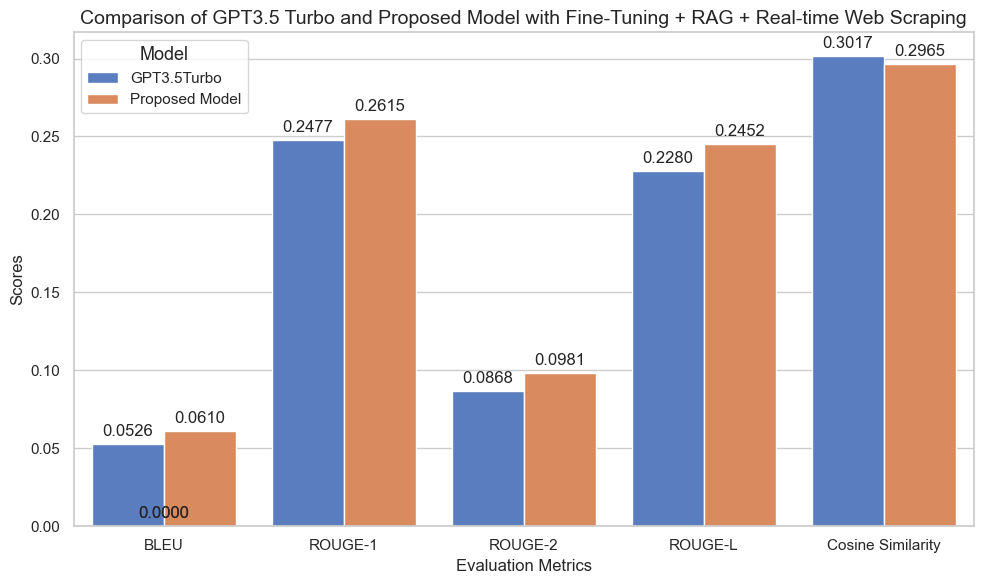

In [312]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Define the figure size
plt.figure(figsize=(10, 6))

# Create a bar plot
bar_plot = sns.barplot(x='Metrics', y='value', hue='variable', 
                       data=pd.melt(df_compare, id_vars=['Metrics'], value_vars=['GPT3.5Turbo', 'Proposed Model']),
                       palette='muted')

# Add labels and title
plt.title('Comparison of GPT3.5 Turbo and Proposed Model with Fine-Tuning + RAG + Real-time Web Scraping', fontsize=14)
plt.xlabel('Evaluation Metrics', fontsize=12)
plt.ylabel('Scores', fontsize=12)

# Adding value labels on the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.4f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

# Display the legend
plt.legend(title='Model', title_fontsize='13', fontsize='11')

# Show the plot
plt.tight_layout()
plt.show()

## Compare Time

In [324]:
import time
import numpy as np

In [325]:
# Example questions for testing
example_questions = [
    "What are the requirements for performing Umrah?",
    "Can you provide the current flight prices from London to Jeddah?",
    "What is the weather like in Makkah today?",
    "How to change the intention (niyyah) in Ihram?",
    "What are the best hotels near the Kaaba in Makkah?"
]

# Function to measure response time for the base model
def measure_response_time_base_model(model_id, examples):
    times = []
    for query in examples:
        start_time = time.time()
        response = openai.chat.completions.create(
            model=model_id,
            messages=[{"role": "user", "content": query}],
            max_tokens=150
        )
        end_time = time.time()
        times.append(end_time - start_time)
    average_time = np.mean(times)
    return average_time

# Function to measure response time for the proposed model
def measure_response_time_proposed_model(examples):
    times = []
    for query in examples:
        start_time = time.time()
        response = ai_umrah_assistant_response(query)
        end_time = time.time()
        times.append(end_time - start_time)
    average_time = np.mean(times)
    return average_time

# Compare runtime average for both models
def compare_model_runtime():
    base_model_id = "gpt-3.5-turbo"
    
    # Measure response time for base GPT-3.5 Turbo model
    print("Measuring response time for the base GPT-3.5 Turbo model...")
    base_model_avg_time = measure_response_time_base_model(base_model_id, example_questions)
    print(f"Average response time for base model: {base_model_avg_time:.4f} seconds")
    
    # Measure response time for proposed fine-tuned model
    print("Measuring response time for the proposed fine-tuned model...")
    proposed_model_avg_time = measure_response_time_proposed_model(example_questions)
    print(f"Average response time for proposed model: {proposed_model_avg_time:.4f} seconds")
    
    return base_model_avg_time, proposed_model_avg_time

# Run the comparison
if __name__ == "__main__":
    base_time, proposed_time = compare_model_runtime()
    print(f"Base Model Average Time: {base_time:.4f} seconds")
    print(f"Proposed Model Average Time: {proposed_time:.4f} seconds")
    print(f"Proposed model is {'slower' if proposed_time > base_time else 'faster'} by {abs(proposed_time - base_time):.4f} seconds on average.")

Measuring response time for the base GPT-3.5 Turbo model...
Average response time for base model: 1.8835 seconds
Measuring response time for the proposed fine-tuned model...
Average response time for proposed model: 9.1725 seconds
Base Model Average Time: 1.8835 seconds
Proposed Model Average Time: 9.1725 seconds
Proposed model is slower by 7.2891 seconds on average.


In [330]:
# Function to measure response time for the base model
def measure_response_time_base_model(model_id, examples):
    times = []
    for query in examples:
        start_time = time.time()
        response = openai.chat.completions.create(
            model=model_id,
            messages=[{"role": "user", "content": query}],
            max_tokens=150
        )
        end_time = time.time()
        times.append(end_time - start_time)
    return times

# Function to measure response time for the proposed model
def measure_response_time_proposed_model(examples):
    times = []
    for query in examples:
        start_time = time.time()
        response = ai_umrah_assistant_response(query)
        end_time = time.time()
        times.append(end_time - start_time)
    return times

# Measure response times for both models
base_model_times = measure_response_time_base_model("gpt-3.5-turbo", example_questions)
proposed_model_times = measure_response_time_proposed_model(example_questions)

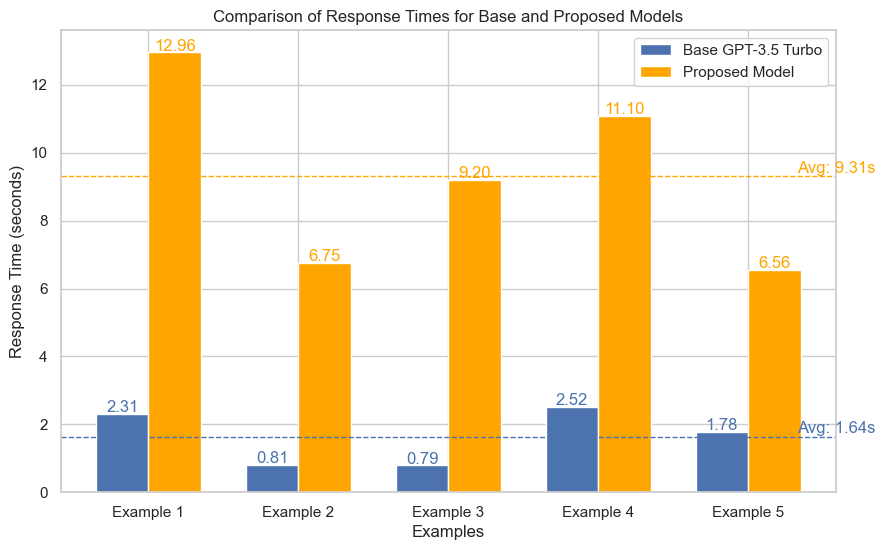

In [331]:
def plot_runtime_comparison(base_times, proposed_times, questions):
    indices = np.arange(len(questions))
    width = 0.35  # Width of the bars

    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")

    # Plotting the bar chart
    plt.bar(indices, base_times, width, label='Base GPT-3.5 Turbo', color='b')
    plt.bar(indices + width, proposed_times, width, label='Proposed Model', color='orange')

    # Calculate and plot the average response time lines
    avg_base_time = np.mean(base_times)
    avg_proposed_time = np.mean(proposed_times)

    plt.axhline(avg_base_time, color='b', linestyle='--', linewidth=1)
    plt.axhline(avg_proposed_time, color='orange', linestyle='--', linewidth=1)

    # Label the averages on the plot
    plt.text(len(questions) - 0.5, avg_base_time + 0.01, f'Avg: {avg_base_time:.2f}s', color='b', va='bottom')
    plt.text(len(questions) - 0.5, avg_proposed_time + 0.01, f'Avg: {avg_proposed_time:.2f}s', color='orange', va='bottom')

    # Setting labels and title
    plt.xlabel('Examples')
    plt.ylabel('Response Time (seconds)')
    plt.title('Comparison of Response Times for Base and Proposed Models')
    plt.xticks(indices + width / 2, [f'Example {i+1}' for i in range(len(questions))])
    plt.legend(loc='best')

    # Annotate each bar with the respective response time value
    for i, (base_time, proposed_time) in enumerate(zip(base_times, proposed_times)):
        plt.text(i, base_time + 0.05, f'{base_time:.2f}', ha='center', color='b')
        plt.text(i + width, proposed_time + 0.05, f'{proposed_time:.2f}', ha='center', color='orange')

    plt.show()

plot_runtime_comparison(base_model_times, proposed_model_times, example_questions)